In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader ,random_split
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
dataset_path = "/kaggle/input/sensor-data"

In [3]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    Applies a Butterworth low-pass filter.

    Parameters:
        data (array-like): The data to filter.
        cutoff (float): The cutoff frequency.
        fs (float): The sampling frequency.
        order (int): The order of the filter.

    Returns:
        y (array-like): The filtered data.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    if normal_cutoff >= 1:
        print(f"Warning: cutoff frequency {cutoff} Hz is too high for the sampling rate {fs:.2f} Hz. Adjusting normalized cutoff to 0.99.")
        normal_cutoff = 0.99
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def extract_features_from_file(file_path, cutoff=3, order=4):
    """
    Loads sensor data from a JSON file, computes features, applies a Butterworth
    low-pass filter on the acceleration magnitude, and returns the feature array
    and the full DataFrame.
    
    Parameters:
        file_path (str): Path to the JSON file.
        cutoff (float): Cutoff frequency for the low-pass filter.
        order (int): Order of the Butterworth filter.
        
    Returns:
        features (np.ndarray): Array of features per time step.
        df (DataFrame): DataFrame containing the original and computed features.
    """
    # Load JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Convert time column to datetime and sort
    df['time'] = pd.to_datetime(df['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values('time')
    
    # Drop rows with missing critical values
    df = df.dropna(subset=['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz'])
    
    # Compute time difference (delta_time in seconds)
    df['delta_time'] = df['time'].diff().dt.total_seconds().fillna(0)
    
    # Compute acceleration magnitude: sqrt(ax^2 + ay^2 + az^2)
    df['acc_mag'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
    
    # Estimate sampling frequency from median delta_time (use default if zero)
    dt_median = df['delta_time'][df['delta_time'] > 0].median() if (df['delta_time'] > 0).any() else 0.02
    fs = 1 / dt_median if dt_median > 0 else 250 # default to 50 Hz if needed
    
        
    # Apply Butterworth low-pass filter to acc_mag
    df['acc_mag_filt'] = butter_lowpass_filter(df['acc_mag'], cutoff, fs, order)
    
    # Compute gyroscope magnitude: sqrt(gx^2 + gy^2 + gz^2)
    df['gyro_mag'] = np.sqrt(df['gx']**2 + df['gy']**2 + df['gz']**2)
    
    # Compute rate of change (first difference) for gyroscope data
    df['gx_diff'] = df['gx'].diff().fillna(0)
    df['gy_diff'] = df['gy'].diff().fillna(0)
    df['gz_diff'] = df['gz'].diff().fillna(0)
    
    # Encode metadata side: left=0, right=1
    df['side_encoded'] = df['metadata'].apply(lambda x: 0 if x['side'] == 'L' else 1)
    
    # Define our feature order (total 13 features):
    # 1-3: Raw accelerometer: ax, ay, az
    # 4-6: Raw gyroscope: gx, gy, gz
    # 7: Filtered acceleration magnitude (acc_mag_filt)
    # 8: Gyroscope magnitude
    # 9-11: Rate-of-change for gyroscope: gx_diff, gy_diff, gz_diff
    # 12: Delta time
    # 13: Side (binary encoded)
    features = df[['ax', 'ay', 'az', 
                   'gx', 'gy', 'gz', 
                   'acc_mag_filt',  # Using filtered acc_mag for training
                   'gyro_mag', 
                   'gx_diff', 'gy_diff', 'gz_diff',
                   'delta_time', 'side_encoded']].values.astype(np.float32)



    
    return features, df

# def count_steps(df, fileName, prominence=0.2, distance=100):
#     """
#     Count steps using peak detection on the filtered acceleration magnitude 
#     (acc_mag_filt) separately for left and right sides.
    
#     Parameters:
#         df (DataFrame): The DataFrame with sensor data and computed features.
#         prominence (float): Prominence parameter for peak detection.
#         distance (int): Minimum distance between peaks.
        
#     Returns:
#         tuple: (left_step_count, right_step_count)
#     """
#     # Separate data by side using metadata
#     left_df = df[df['metadata'].apply(lambda x: x['side'] == 'L')]
#     right_df = df[df['metadata'].apply(lambda x: x['side'] == 'R')]
    
#     # Detect peaks in filtered acceleration magnitude for left side
#     left_peaks, _ = find_peaks(left_df['acc_mag_filt'], prominence=prominence, distance=distance)
    
#     # Detect peaks in filtered acceleration magnitude for right side
#     right_peaks, _ = find_peaks(right_df['acc_mag_filt'], prominence=prominence, distance=distance)
    
#     return len(left_peaks), len(right_peaks)

def count_steps(df, fileName, prominence=0.2, distance=None, desired_interval=0.3):
    """
    Count steps using peak detection on the filtered acceleration magnitude 
    (acc_mag_filt) separately for left and right sides.
    
    Parameters:
        df (DataFrame): The DataFrame with sensor data and computed features.
        prominence (float): Prominence parameter for peak detection.
        distance (int or None): Minimum distance between peaks (in samples). If None, it
                                will be computed using desired_interval and the sampling frequency.
        desired_interval (float): Desired minimum time between peaks in seconds (used if distance is None).
        
    Returns:
        tuple: (left_step_count, right_step_count)
    """
    # print("file is " , fileName)
    # If distance is not provided, compute it based on the median delta_time (i.e. sampling frequency)
    if distance is None:
        dt_median = df['delta_time'][df['delta_time'] > 0].median() if (df['delta_time'] > 0).any() else 0.02
        # print("dt Median", dt_median)
        fs = 1 / dt_median if dt_median > 0 else 250  # default fs if dt_median is zero
        distance = int(fs * desired_interval)
        # print("Computed sampling frequency (fs):", fs)
        # print("Computed distance (in samples) based on desired_interval =", desired_interval, "sec:", distance)
    
    # Separate data by side using metadata
    left_df = df[df['metadata'].apply(lambda x: x['side'] == 'L')]
    right_df = df[df['metadata'].apply(lambda x: x['side'] == 'R')]
    
    # Detect peaks in filtered acceleration magnitude for left side
    left_peaks, _ = find_peaks(left_df['acc_mag_filt'], prominence=prominence, distance=100)
    
    # Detect peaks in filtered acceleration magnitude for right side
    right_peaks, _ = find_peaks(right_df['acc_mag_filt'], prominence=prominence, distance=100)
    
    return len(left_peaks), len(right_peaks)


In [4]:
file_paths = glob.glob(os.path.join(dataset_path, "*.json"))

results = []

for fp in file_paths:
    try:
        features, df = extract_features_from_file(fp, cutoff=3, order=4)
        # Compute step counts using the count_steps function
        left_steps, right_steps = count_steps(df, fileName=fp, prominence=0.2, distance=None, desired_interval=0.3)
        
        measurement_id = os.path.basename(fp).replace(".json", "")
        start_time = df['time'].iloc[0].strftime("%Y-%m-%d %H:%M:%S.%f")
        end_time = df['time'].iloc[-1].strftime("%Y-%m-%d %H:%M:%S.%f")
        
        results.append({
            "measurement_id": measurement_id,
            "start_time": start_time,
            "end_time": end_time,
            "left_steps": left_steps,
            "right_steps": right_steps
        })
    except Exception as e:
        print("Error processing file:", fp, "\n", e)

output_file = "/kaggle/working/calculated_steps_algo.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)
    
print(f"Saved predictions for {len(results)} files in {output_file}")

Saved predictions for 234 files in /kaggle/working/calculated_steps_algo.json


Visulization to check the various features vs time 

/kaggle/input/sensor-data/4woc10tIodbQb8cnVOlP.json
Left step count: 14
Right step count: 14
Total (Left+Right): 28
Whole DataFrame step count: 14

Timestamps for Whole DataFrame Peaks:
2024-06-14 11:36:59.164000
2024-06-14 11:36:59.680000
2024-06-14 11:37:00.232000
2024-06-14 11:37:00.749000
2024-06-14 11:37:01.290000
2024-06-14 11:37:01.801000
2024-06-14 11:37:02.337000
2024-06-14 11:37:02.840000
2024-06-14 11:37:03.377000
2024-06-14 11:37:03.873000
2024-06-14 11:37:04.403000
2024-06-14 11:37:04.903000
2024-06-14 11:37:05.460000
2024-06-14 11:37:05.920000

Timestamps for Left Foot Peaks:
2024-06-14 11:36:59.164000
2024-06-14 11:36:59.680000
2024-06-14 11:37:00.231000
2024-06-14 11:37:00.749000
2024-06-14 11:37:01.290000
2024-06-14 11:37:01.801000
2024-06-14 11:37:02.338000
2024-06-14 11:37:02.840000
2024-06-14 11:37:03.377000
2024-06-14 11:37:03.872000
2024-06-14 11:37:04.403000
2024-06-14 11:37:04.904000
2024-06-14 11:37:05.460000
2024-06-14 11:37:05.920000

Timestamps for Right Foo

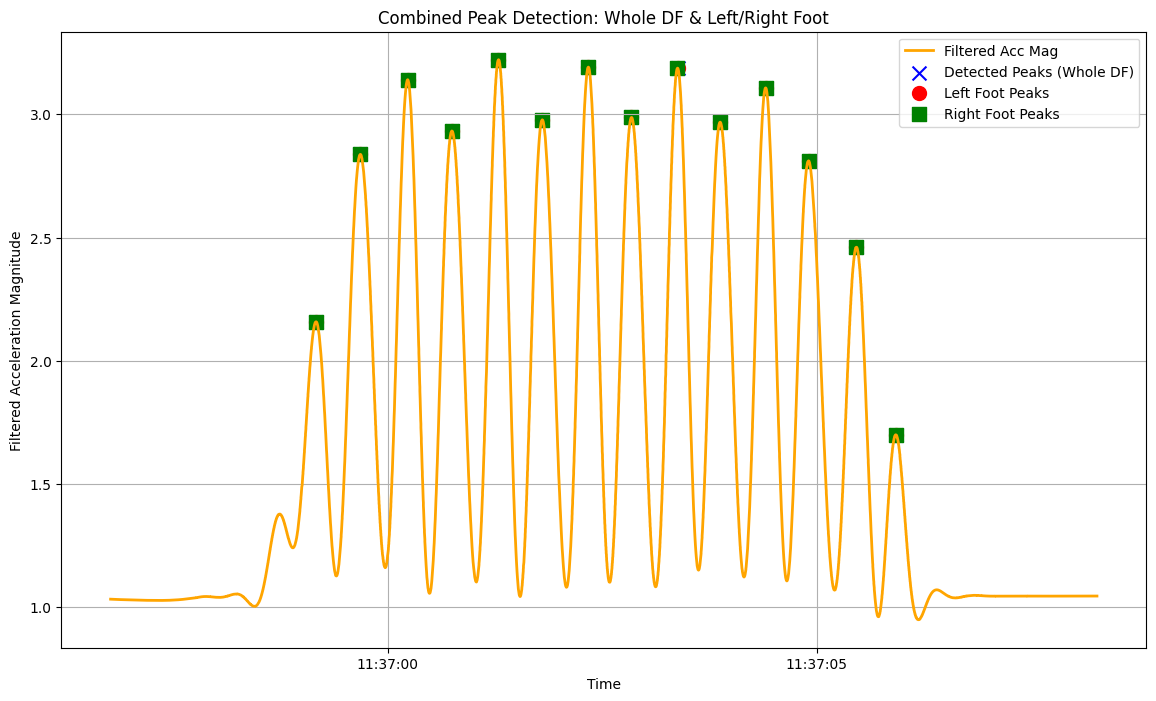

Left step count: 9
Right step count: 5
Total step count: 14


In [5]:
# Get a sample file (e.g., the 26th file)
file_paths = glob.glob(os.path.join(dataset_path, "*.json"))
sample_file = file_paths[25]
print(sample_file)
features, df = extract_features_from_file(sample_file, cutoff=3, order=4)

# Define peak detection parameters
prominence = 0.2
distance = 50  # adjust based on high sampling frequency

# --- Detect peaks separately for left and right ---
# Separate DataFrame by metadata (left/right)
left_df = df[df['metadata'].apply(lambda x: x['side'] == 'L')]
right_df = df[df['metadata'].apply(lambda x: x['side'] == 'R')]

# Detect peaks for left side
left_peaks, _ = find_peaks(left_df['acc_mag_filt'], prominence=prominence, distance=distance)
# Detect peaks for right side
right_peaks, _ = find_peaks(right_df['acc_mag_filt'], prominence=prominence, distance=distance)

# Total left+right step count
lr_count = len(left_peaks) + len(right_peaks)

# --- Detect peaks on the entire DataFrame ---
all_peaks, _ = find_peaks(df['acc_mag_filt'], prominence=prominence, distance=distance)
all_count = len(all_peaks)

# Print the results for comparison
print("Left step count:", len(left_peaks))
print("Right step count:", len(right_peaks))
print("Total (Left+Right):", lr_count)
print("Whole DataFrame step count:", all_count)

# Print the timestamps for each set of peaks
print("\nTimestamps for Whole DataFrame Peaks:")
for t in df['time'].iloc[all_peaks]:
    print(t)

print("\nTimestamps for Left Foot Peaks:")
for t in left_df['time'].iloc[left_peaks]:
    print(t)

print("\nTimestamps for Right Foot Peaks:")
for t in right_df['time'].iloc[right_peaks]:
    print(t)

# -------------------------------------------
# Visualization: Combined Peak Detection Plot
# -------------------------------------------
plt.figure(figsize=(14, 8))

# Plot the filtered acceleration magnitude signal
plt.plot(df['time'], df['acc_mag_filt'], label="Filtered Acc Mag", color='orange', linewidth=2)

# Plot peaks from the whole DataFrame
plt.scatter(df['time'].iloc[all_peaks], df['acc_mag_filt'].iloc[all_peaks],
            color='blue', marker='x', s=100, label="Detected Peaks (Whole DF)")

# Plot left foot peaks
plt.scatter(left_df['time'].iloc[left_peaks], left_df['acc_mag_filt'].iloc[left_peaks],
            color='red', marker='o', s=100, label="Left Foot Peaks")

# Plot right foot peaks
plt.scatter(right_df['time'].iloc[right_peaks], right_df['acc_mag_filt'].iloc[right_peaks],
            color='green', marker='s', s=100, label="Right Foot Peaks")

plt.xlabel("Time")
plt.ylabel("Filtered Acceleration Magnitude")
plt.title("Combined Peak Detection: Whole DF & Left/Right Foot")
plt.legend()
plt.grid(True)
plt.show()



# Detect peaks on the whole DataFrame
all_peaks, _ = find_peaks(df['acc_mag_filt'], prominence=prominence, distance=distance)

# Initialize counters
left_count = 0
right_count = 0

# For each detected peak, check the metadata side at that time
for idx in all_peaks:
    side = df['metadata'].iloc[idx]['side']
    if side == 'L':
        left_count += 1
    elif side == 'R':
        right_count += 1

print("Left step count:", left_count)
print("Right step count:", right_count)
print("Total step count:", left_count + right_count)

Number of samples for left side: 4309 and right side: 4758

Left step peak times:
2024-06-14 11:36:59.164000
2024-06-14 11:37:00.231000
2024-06-14 11:37:01.290000
2024-06-14 11:37:02.338000
2024-06-14 11:37:03.377000
2024-06-14 11:37:04.403000
2024-06-14 11:37:05.460000

Right step peak times:
2024-06-14 11:36:59.165000
2024-06-14 11:37:00.232000
2024-06-14 11:37:01.290000
2024-06-14 11:37:02.337000
2024-06-14 11:37:03.376000
2024-06-14 11:37:04.402000
2024-06-14 11:37:05.460000

Total steps (L+R): 14


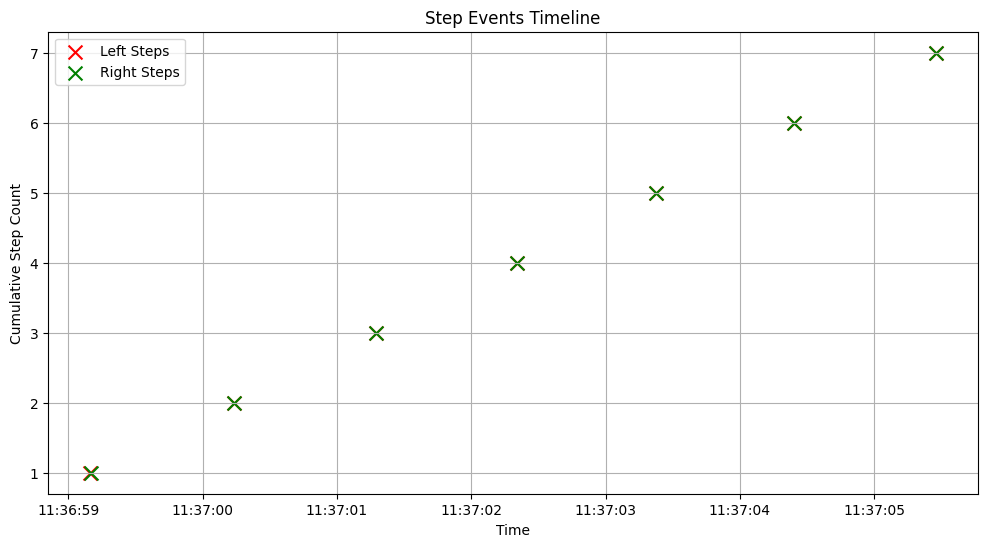

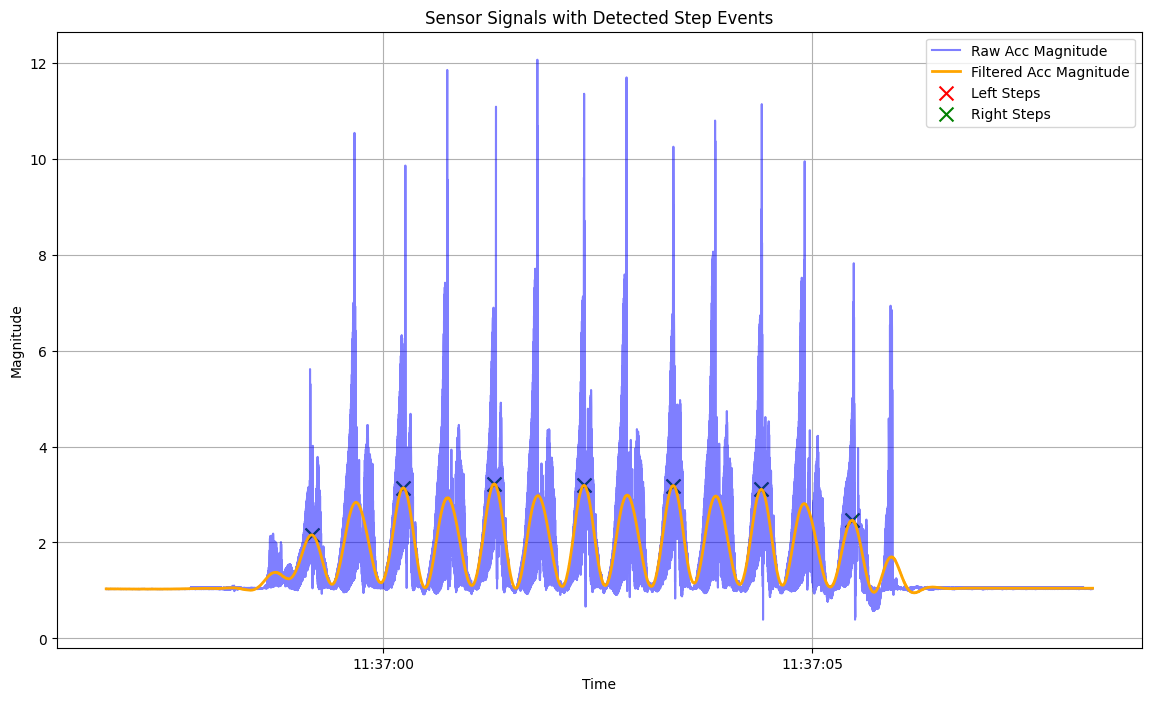

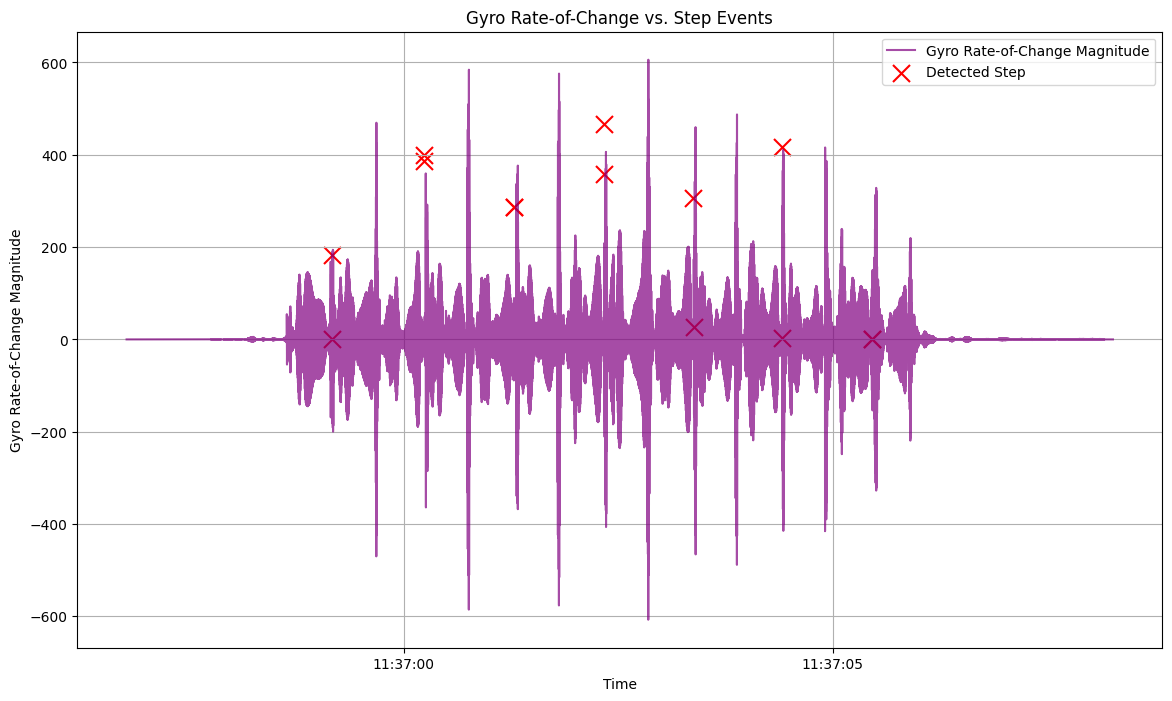

In [6]:

# Get a sample file (e.g., the 101st file)
file_paths = glob.glob(os.path.join(dataset_path, "*.json"))
sample_file = file_paths[25]
features, df = extract_features_from_file(sample_file, cutoff=3, order=4)

# Print sampling frequency for confirmation (fs is computed inside extract_features_from_file)
# (Note: the extract_features_from_file function prints "fs" inside the butter_lowpass_filter)

# Define peak detection parameters
prominence = 0.2
distance = 250  # adjust based on high sampling frequency

# Separate the DataFrame by metadata (left/right)
left_df = df[df['metadata'].apply(lambda x: x['side'] == 'L')]
right_df = df[df['metadata'].apply(lambda x: x['side'] == 'R')]

print("Number of samples for left side:", len(left_df), "and right side:", len(right_df))

# Detect peaks on the filtered acceleration magnitude for each side
left_peaks, _ = find_peaks(left_df['acc_mag_filt'], prominence=prominence, distance=distance)
right_peaks, _ = find_peaks(right_df['acc_mag_filt'], prominence=prominence, distance=distance)

# Print out the step (peak) times for each side
print("\nLeft step peak times:")
for t in left_df['time'].iloc[left_peaks]:
    print(t)

print("\nRight step peak times:")
for t in right_df['time'].iloc[right_peaks]:
    print(t)

# Total steps (L + R)
total_steps = len(left_peaks) + len(right_peaks)
print("\nTotal steps (L+R):", total_steps)

# -------------------------------------------
# Visualization 1: Step Timeline Plot (for reference)
# -------------------------------------------
plt.figure(figsize=(12, 6))
left_steps = range(1, len(left_peaks)+1)
right_steps = range(1, len(right_peaks)+1)
plt.scatter(left_df['time'].iloc[left_peaks], left_steps, color='red', marker='x', s=100, label='Left Steps')
plt.scatter(right_df['time'].iloc[right_peaks], right_steps, color='green', marker='x', s=100, label='Right Steps')
plt.xlabel('Time')
plt.ylabel('Cumulative Step Count')
plt.title('Step Events Timeline')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------
# Visualization 2: Multi-signal Plot with Step Markers
# -------------------------------------------
plt.figure(figsize=(14, 8))

# Plot raw acceleration magnitude
plt.plot(df['time'], df['acc_mag'], label='Raw Acc Magnitude', alpha=0.5, color='blue')

# Plot filtered acceleration magnitude
plt.plot(df['time'], df['acc_mag_filt'], label='Filtered Acc Magnitude', linewidth=2, color='orange')

# Overlay detected step markers on filtered acceleration magnitude
plt.scatter(left_df['time'].iloc[left_peaks], left_df['acc_mag_filt'].iloc[left_peaks],
            color='red', marker='x', s=100, label='Left Steps')
plt.scatter(right_df['time'].iloc[right_peaks], right_df['acc_mag_filt'].iloc[right_peaks],
            color='green', marker='x', s=100, label='Right Steps')

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Sensor Signals with Detected Step Events')
plt.legend()
plt.grid(True)
plt.show()


# Visualization 3: Rate of Change of Gyro vs Step Taken
# -------------------------------------------
# Compute the magnitude of the rate-of-change of gyro data for the entire DataFrame.
# (This is computed from gx_diff, gy_diff, and gz_diff)
df['gyro_diff_mag'] = np.sqrt(df['gx_diff']**2 + df['gy_diff']**2 + df['gz_diff']**2)

plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['gx_diff'], label='Gyro Rate-of-Change Magnitude', color='purple', alpha=0.7)

# To overlay step markers on this plot, we need the step times.
# Here, we'll combine the left and right step times into one sorted list.
left_times = list(left_df['time'].iloc[left_peaks])
right_times = list(right_df['time'].iloc[right_peaks])
all_step_times = sorted(left_times + right_times)

# For each step time, extract the corresponding gyro_diff_mag value
step_gyro_vals = []
for t in all_step_times:
    # Find the index in the full df corresponding to this time (closest match)
    idx = (df['time'] - t).abs().idxmin()
    step_gyro_vals.append(df['gyro_diff_mag'].iloc[idx])

plt.scatter(all_step_times, step_gyro_vals, color='red', marker='x', s=150, label='Detected Step')
plt.xlabel('Time')
plt.ylabel('Gyro Rate-of-Change Magnitude')
plt.title('Gyro Rate-of-Change vs. Step Events')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
class SensorDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.data = []
        self.labels = []
        for fp in file_paths:
            features, df = extract_features_from_file(fp)
            left_steps, right_steps = count_steps(df,fp)
            self.data.append(torch.tensor(features))  # shape: [T, 13]
            self.labels.append(torch.tensor([left_steps, right_steps], dtype=torch.float32))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    """
    Pads sequences in a batch to the maximum length in that batch.
    Returns:
      - padded_seq: Tensor of shape [batch_size, max_seq_length, feature_dim]
      - labels: Tensor of shape [batch_size, 2]
      - lengths: list of original sequence lengths (if needed for further processing)
    """
    sequences, labels = zip(*batch)
    lengths = [seq.shape[0] for seq in sequences]
    padded_seq = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return padded_seq, labels, lengths

# Get all JSON file paths (adjust the path as needed)
file_paths = glob.glob(os.path.join(dataset_path, "*.json"))

# # Create dataset and DataLoader
dataset = SensorDataset(file_paths)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Split dataset: 80% training, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


Training samples: 187, Validation samples: 47


In [8]:
# Get list of JSON file paths (adjust the folder path if needed)
file_paths = glob.glob(os.path.join(dataset_path, "*.json"))

# Check if we have at least one file
if not file_paths:
    print("No files found in the sensor_data directory.")
else:
    # Use the first file to inspect the DataFrame
    sample_file = file_paths[0]
    features, df = extract_features_from_file(sample_file)
    
    print("DataFrame for sample file:", os.path.basename(sample_file))
    print(df.head(100))  # print first 10 rows to inspect the features
    
    # Now, print the computed step counts (left and right) for a few sample files
    print("\nStep counts for a few files:")
    for fp in file_paths[:15]:  # adjust the number of files to inspect as needed
        features, df = extract_features_from_file(fp)
        left_steps, right_steps = count_steps(df,fp)
        print(f"File: {os.path.basename(fp)} | Left steps: {left_steps}, Right steps: {right_steps}")

DataFrame for sample file: 0iE2x5VeObt4lVsIU3L4.json
                        time       metadata    gy    gx        ay    gz  \
2268 2024-06-14 12:00:31.668  {'side': 'R'} -0.07 -0.49  0.002440 -0.63   
2269 2024-06-14 12:00:31.672  {'side': 'R'} -0.07 -0.56  0.000000 -0.56   
2270 2024-06-14 12:00:31.677  {'side': 'R'} -0.07 -0.56  0.000976 -0.56   
2271 2024-06-14 12:00:31.682  {'side': 'R'} -0.07 -0.63  0.003904 -0.56   
2272 2024-06-14 12:00:31.687  {'side': 'R'}  0.00 -0.56  0.001952 -0.56   
...                      ...            ...   ...   ...       ...   ...   
2363 2024-06-14 12:00:32.129  {'side': 'R'}  0.77 -0.49  0.001464 -0.42   
2364 2024-06-14 12:00:32.133  {'side': 'R'}  0.77 -0.49 -0.000488 -0.49   
2365 2024-06-14 12:00:32.138  {'side': 'R'}  0.91 -0.49  0.003416 -0.49   
2366 2024-06-14 12:00:32.143  {'side': 'R'}  0.77 -0.49  0.000976 -0.56   
2367 2024-06-14 12:00:32.148  {'side': 'R'}  0.91 -0.42  0.002928 -0.56   

            ax        az  delta_time   acc_mag

In [9]:
class UnifiedCountLSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)  # Output: [left_steps, right_steps]
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output from the last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  # shape: [batch_size, 2]

# Instantiate the model and move it to the device
model = UnifiedCountLSTM(input_size=13, hidden_size=64, num_layers=2).to(device)


In [10]:
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output: [left_steps, right_steps]
        
    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use the output from the last time step
        out = self.fc(out)
        return out

# Example instantiation:
model_LSTM = SimpleLSTM(input_size=13, hidden_size=64, num_layers=1).to(device)


In [11]:
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, input_size=13, cnn_channels=32, hidden_size=128, num_layers=2):
        super().__init__()
        # Input shape: (batch, time, features) -> for conv1d, we need (batch, features, time)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # Reduce time resolution
        self.lstm = nn.LSTM(cnn_channels, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, 2)
    
    def forward(self, x):
        # x shape: (batch, time, features)
        x = x.permute(0, 2, 1)  # -> (batch, features, time)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # -> (batch, time, cnn_channels)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Instantiate and move to device
model_CNN = CNN_LSTM(input_size=13, cnn_channels=32, hidden_size=128, num_layers=2).to(device)


In [12]:
# import torch.nn as nn

class UnifiedCountGRU(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)  # Output: [left_steps, right_steps]
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # use output from the last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  # shape: [batch_size, 2]

# Instantiate and move to device (e.g., CPU or GPU)
model_GRU= UnifiedCountGRU(input_size=13, hidden_size=64, num_layers=2).to(device)


Epoch 1/100, Train Loss: 119.1214, Val Loss: 36.6516
Epoch 2/100, Train Loss: 21.7237, Val Loss: 15.7155
Epoch 3/100, Train Loss: 17.2717, Val Loss: 15.4877
Epoch 4/100, Train Loss: 17.3289, Val Loss: 15.4056
Epoch 5/100, Train Loss: 17.1442, Val Loss: 15.6199
Epoch 6/100, Train Loss: 17.3934, Val Loss: 15.7363
Epoch 7/100, Train Loss: 17.2055, Val Loss: 15.3272
Epoch 8/100, Train Loss: 17.4062, Val Loss: 15.4104
Epoch 9/100, Train Loss: 17.1956, Val Loss: 15.6707
Epoch 10/100, Train Loss: 17.4334, Val Loss: 16.1982
Epoch 11/100, Train Loss: 17.4055, Val Loss: 15.6801
Epoch 12/100, Train Loss: 17.2844, Val Loss: 15.5319
Epoch 13/100, Train Loss: 17.1529, Val Loss: 15.3829
Epoch 14/100, Train Loss: 17.2386, Val Loss: 15.5273
Epoch 15/100, Train Loss: 17.2128, Val Loss: 15.4404
Epoch 16/100, Train Loss: 17.3695, Val Loss: 15.4030
Epoch 17/100, Train Loss: 16.2845, Val Loss: 14.0949
Epoch 18/100, Train Loss: 15.4400, Val Loss: 15.5755
Epoch 19/100, Train Loss: 15.8397, Val Loss: 15.1843
E

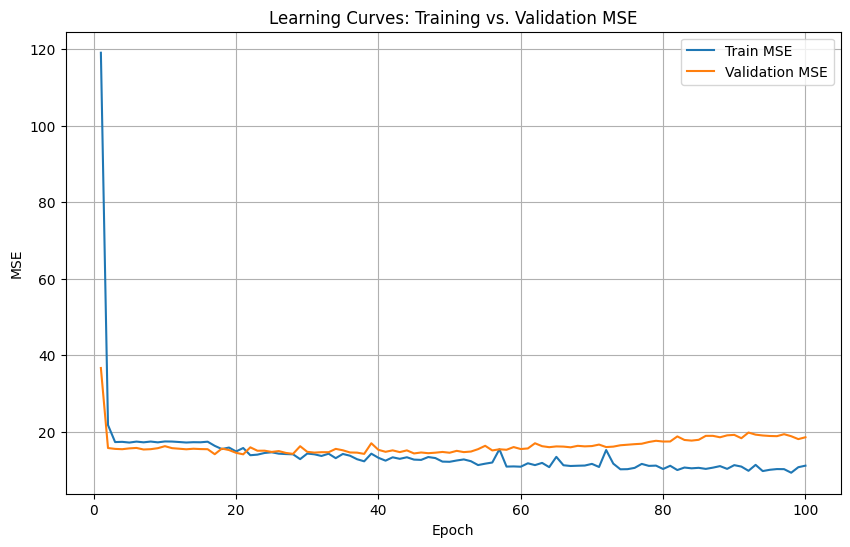

In [13]:
# criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 100  # Adjust as needed

# model.train()
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for sequences, labels, lengths in dataloader:
#         # Move data to device
#         sequences = sequences.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(sequences)  # shape: [batch_size, 2]
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
    
#     avg_loss = running_loss / len(dataloader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


# Define criterion and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Adjust as needed
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    # Training phase
    model.train()
    for sequences, labels, lengths in train_dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)  # shape: [batch_size, 2]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for sequences, labels, lengths in val_dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train MSE")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curves: Training vs. Validation MSE")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100, Train Loss: 112.1113, Val Loss: 32.2721
Epoch 2/100, Train Loss: 19.6734, Val Loss: 15.5031
Epoch 3/100, Train Loss: 17.1395, Val Loss: 15.4271
Epoch 4/100, Train Loss: 17.1730, Val Loss: 15.4342
Epoch 5/100, Train Loss: 17.3477, Val Loss: 15.3240
Epoch 6/100, Train Loss: 16.9903, Val Loss: 16.1569
Epoch 7/100, Train Loss: 17.4982, Val Loss: 15.5254
Epoch 8/100, Train Loss: 17.3230, Val Loss: 15.5669
Epoch 9/100, Train Loss: 17.2326, Val Loss: 15.3289
Epoch 10/100, Train Loss: 17.1938, Val Loss: 15.3269
Epoch 11/100, Train Loss: 17.1118, Val Loss: 15.4618
Epoch 12/100, Train Loss: 17.4744, Val Loss: 14.7919
Epoch 13/100, Train Loss: 15.1472, Val Loss: 13.5472
Epoch 14/100, Train Loss: 15.0217, Val Loss: 13.7886
Epoch 15/100, Train Loss: 14.3272, Val Loss: 14.0902
Epoch 16/100, Train Loss: 14.1760, Val Loss: 14.0900
Epoch 17/100, Train Loss: 13.8214, Val Loss: 14.6533
Epoch 18/100, Train Loss: 15.1719, Val Loss: 13.9141
Epoch 19/100, Train Loss: 14.4990, Val Loss: 13.7673
E

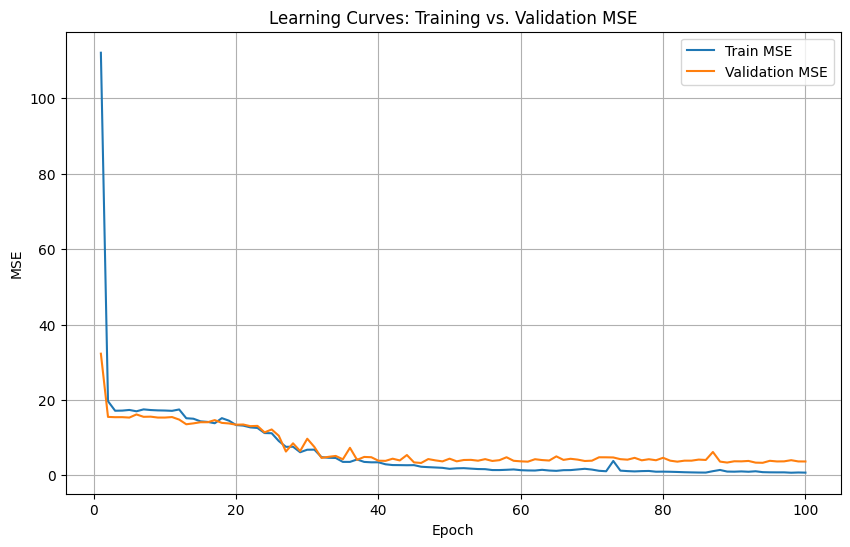

In [14]:
model = model_GRU
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Adjust as needed
train_losses = []
val_losses = []


model.train()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    # Training phase
    model.train()
    for sequences, labels, lengths in train_dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)  # shape: [batch_size, 2]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for sequences, labels, lengths in val_dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train MSE")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curves: Training vs. Validation MSE")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100, Train Loss: 76.6184, Val Loss: 15.4828
Epoch 2/100, Train Loss: 17.7202, Val Loss: 15.3622
Epoch 3/100, Train Loss: 17.3705, Val Loss: 15.5827
Epoch 4/100, Train Loss: 17.1346, Val Loss: 15.5968
Epoch 5/100, Train Loss: 17.4070, Val Loss: 16.1761
Epoch 6/100, Train Loss: 17.1732, Val Loss: 16.1148
Epoch 7/100, Train Loss: 17.5240, Val Loss: 15.3275
Epoch 8/100, Train Loss: 17.2449, Val Loss: 15.3258
Epoch 9/100, Train Loss: 17.1787, Val Loss: 16.0822
Epoch 10/100, Train Loss: 17.5388, Val Loss: 15.4407
Epoch 11/100, Train Loss: 17.2549, Val Loss: 15.5614
Epoch 12/100, Train Loss: 17.4387, Val Loss: 15.9418
Epoch 13/100, Train Loss: 17.0850, Val Loss: 15.3165
Epoch 14/100, Train Loss: 17.2420, Val Loss: 15.5172
Epoch 15/100, Train Loss: 17.1703, Val Loss: 14.4668
Epoch 16/100, Train Loss: 17.1054, Val Loss: 14.0384
Epoch 17/100, Train Loss: 15.2246, Val Loss: 14.2280
Epoch 18/100, Train Loss: 15.4099, Val Loss: 13.6247
Epoch 19/100, Train Loss: 13.3932, Val Loss: 18.8530
Ep

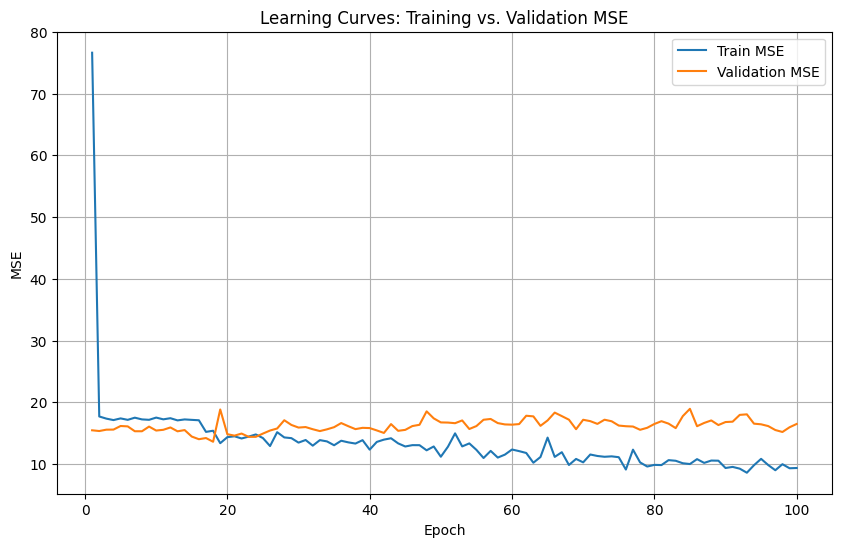

In [15]:

model = model_CNN
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Adjust as needed
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    # Training phase
    model.train()
    for sequences, labels, lengths in train_dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)  # shape: [batch_size, 2]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for sequences, labels, lengths in val_dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train MSE")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curves: Training vs. Validation MSE")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100, Train Loss: 110.2858, Val Loss: 46.2930
Epoch 2/100, Train Loss: 28.9065, Val Loss: 21.5798
Epoch 3/100, Train Loss: 18.5221, Val Loss: 18.3172
Epoch 4/100, Train Loss: 17.3352, Val Loss: 17.7080
Epoch 5/100, Train Loss: 17.2678, Val Loss: 17.7158
Epoch 6/100, Train Loss: 17.4526, Val Loss: 17.5971
Epoch 7/100, Train Loss: 17.1770, Val Loss: 17.7212
Epoch 8/100, Train Loss: 16.8840, Val Loss: 17.5124
Epoch 9/100, Train Loss: 16.6451, Val Loss: 17.1101
Epoch 10/100, Train Loss: 16.7992, Val Loss: 16.2434
Epoch 11/100, Train Loss: 15.6953, Val Loss: 15.7926
Epoch 12/100, Train Loss: 14.6878, Val Loss: 15.2646
Epoch 13/100, Train Loss: 13.7520, Val Loss: 15.8494
Epoch 14/100, Train Loss: 13.9096, Val Loss: 15.6880
Epoch 15/100, Train Loss: 14.2846, Val Loss: 16.6336
Epoch 16/100, Train Loss: 14.6823, Val Loss: 15.7993
Epoch 17/100, Train Loss: 14.4367, Val Loss: 15.3709
Epoch 18/100, Train Loss: 13.7510, Val Loss: 15.3039
Epoch 19/100, Train Loss: 13.5664, Val Loss: 16.5218
E

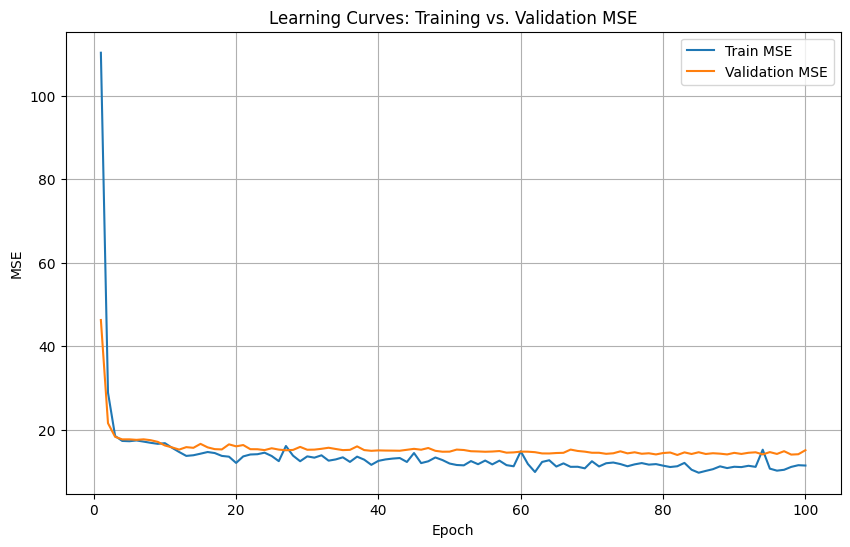

In [16]:
model = model_LSTM
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Adjust as needed
train_losses = []
val_losses = []


model.train()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    # Training phase
    model.train()
    for sequences, labels, lengths in train_dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)  # shape: [batch_size, 2]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for sequences, labels, lengths in val_dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train MSE")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curves: Training vs. Validation MSE")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.eval()
results = []

with torch.no_grad():
    for fp in file_paths:
        features, df = extract_features_from_file(fp)
        # Add batch dimension and move to device: [1, sequence_length, 13]
        input_seq = torch.tensor(features).unsqueeze(0).to(device)
        output = model(input_seq)
        pred_left, pred_right = output.squeeze(0).tolist()
        # Round predictions to nearest integer
        pred_left = int(round(pred_left))
        pred_right = int(round(pred_right))
        
        # Get measurement ID from filename (without extension)
        measurement_id = os.path.basename(fp).replace(".json", "")
        start_time = df['time'].iloc[0].strftime("%Y-%m-%d %H:%M:%S.%f")
        end_time = df['time'].iloc[-1].strftime("%Y-%m-%d %H:%M:%S.%f")
        
        results.append({
            "measurement_id": measurement_id,
            "start_time": start_time,
            "end_time": end_time,
            "left_steps": pred_left,
            "right_steps": pred_right
        })

# Save all predictions to a JSON file
output_file = "/kaggle/working/calculated_steps_GRUTest.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)
    
print(f"Saved predictions for {len(results)} files in {output_file}")


Saved predictions for 234 files in /kaggle/working/calculated_steps_GRUTest.json


In [18]:
import glob
import os
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb


def aggregate_features_from_df(df):
    """
    Aggregate time-series features from a file into a fixed-length vector.
    We compute summary statistics (mean, std, max, min) for several signals.
    """
    agg = {}
    for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'acc_mag_filt', 'gyro_mag']:
        agg[f'{col}_mean'] = df[col].mean()
        agg[f'{col}_std'] = df[col].std()
        agg[f'{col}_max'] = df[col].max()
        agg[f'{col}_min'] = df[col].min()
        
    agg['duration'] = (df['time'].iloc[-1] - df['time'].iloc[0]).total_seconds()
    return agg

# Define the path to your dataset
dataset_path = "/kaggle/input/sensor-data"
file_paths = glob.glob(os.path.join(dataset_path, "*.json"))

# Create lists to hold aggregated features and targets
all_features = []
all_targets = []

# Loop over files to build the dataset
for file in file_paths:
    try:
        # Extract features and DataFrame for the file
        features, df = extract_features_from_file(file, cutoff=3, order=4)
        # Aggregate features over time into a fixed-length vector
        agg_features = aggregate_features_from_df(df)
        # Compute target labels using your count_steps function
        left_steps, right_steps = count_steps(df,file, prominence=0.2, distance=None, desired_interval=0.3)
        agg_features['left_steps'] = left_steps
        agg_features['right_steps'] = right_steps
        all_features.append(agg_features)
    except Exception as e:
        print("Error processing file:", file, "\n", e)

# Create a DataFrame from the aggregated features
df_train = pd.DataFrame(all_features)
print(df_train.head(20))

# Separate predictors and targets
X = df_train.drop(columns=['left_steps', 'right_steps'])
y = df_train[['left_steps', 'right_steps']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train a Random Forest regressor (multi-output)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the performance (Mean Absolute Error for both outputs)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error Test:", mae )


# Train XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("XGBoost MAE:", mae_xgb)

     ax_mean    ax_std     ax_max    ax_min   ay_mean    ay_std    ay_max  \
0   0.078838  1.033468   5.525624 -4.855112  0.019904  0.331730  3.537024   
1   0.114257  1.199923  10.937544 -5.289920  0.000044  0.373103  7.577664   
2   0.054140  0.548828   5.322616 -3.795176 -0.015432  0.180151  3.559960   
3   0.096615  0.378996   4.056744 -1.808528  0.003412  0.181545  2.340448   
4   0.064672  0.533109   5.828672 -1.754848  0.013191  0.232511  2.471720   
5   0.252934  0.992402   6.959856 -3.514576 -0.020556  0.274495  2.907504   
6   0.089039  0.989465   8.348704 -6.354736  0.019711  0.354453  6.685112   
7   0.157535  1.008622  11.068328 -6.166856  0.027638  0.267204  3.731248   
8   0.042727  0.423241   7.082344 -4.798016  0.004005  0.079782  3.312544   
9   0.097459  1.127108   8.570256 -4.173376 -0.002861  0.330017  7.103328   
10  0.176196  0.950986   6.772464 -4.342224  0.027283  0.269227  3.774192   
11  0.065880  0.825077   5.650064 -5.594920  0.039265  0.351009  9.672160   

In [19]:
results = []

for fp in file_paths:
    try:
        # Extract and aggregate features for the file
        features, df = extract_features_from_file(fp, cutoff=3, order=4)
        agg_features = aggregate_features_from_df(df)
        X_file = pd.DataFrame([agg_features])
        # Predict step counts using the trained Random Forest model
        prediction = rf.predict(X_file)[0]
        pred_left = int(round(prediction[0]))
        pred_right = int(round(prediction[1]))
        
        measurement_id = os.path.basename(fp).replace(".json", "")
        start_time = df['time'].iloc[0].strftime("%Y-%m-%d %H:%M:%S.%f")
        end_time = df['time'].iloc[-1].strftime("%Y-%m-%d %H:%M:%S.%f")
        
        results.append({
            "measurement_id": measurement_id,
            "start_time": start_time,
            "end_time": end_time,
            "left_steps": pred_left,
            "right_steps": pred_right
        })
    except Exception as e:
        print("Error processing file:", fp, "\n", e)

output_file = "/kaggle/working/calculated_steps_RandomForestTest.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)
    
print(f"Saved predictions for {len(results)} files in {output_file}")

Saved predictions for 234 files in /kaggle/working/calculated_steps_RandomForestTest.json


In [20]:
results = []

for fp in file_paths:
    try:
        # Extract and aggregate features for the file
        features, df = extract_features_from_file(fp, cutoff=3, order=4)
        agg_features = aggregate_features_from_df(df)
        X_file = pd.DataFrame([agg_features])
        # Predict step counts using the trained Random Forest model
        prediction = xgb_model.predict(X_file)[0]
        pred_left = int(round(prediction[0]))
        pred_right = int(round(prediction[1]))
        
        measurement_id = os.path.basename(fp).replace(".json", "")
        start_time = df['time'].iloc[0].strftime("%Y-%m-%d %H:%M:%S.%f")
        end_time = df['time'].iloc[-1].strftime("%Y-%m-%d %H:%M:%S.%f")
        
        results.append({
            "measurement_id": measurement_id,
            "start_time": start_time,
            "end_time": end_time,
            "left_steps": pred_left,
            "right_steps": pred_right
        })
    except Exception as e:
        print("Error processing file:", fp, "\n", e)

output_file = "/kaggle/working/calculated_steps_XGBoost.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)
    
print(f"Saved predictions for {len(results)} files in {output_file}")

Saved predictions for 234 files in /kaggle/working/calculated_steps_XGBoost.json
